# Support Vector Machine (SVM) approach

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import os
import seaborn as sns
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import itertools

## Data Loading

Load the data, which consists of features (X) and labels (Y), from `.npy` files.

In [3]:
X_original = np.load('archive/X.npy')
Y_original = np.load('archive/Y.npy')

print(X_original.shape)
print(Y_original.shape)

(2062, 64, 64)
(2062, 10)


## Data Organization

Since the dataset is not properly organized, we will organize it by the digit they represent, i.e, we will start with the digit 0 and end with the digit 9.

In [4]:
def save_dataset_with_timestamp(X, Y, prefix='archive/X', suffix='archive/Y'):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    np.save(f'{prefix}_{timestamp}.npy', X)
    np.save(f'{suffix}_{timestamp}.npy', Y)

X = np.copy(X_original)
Y = np.copy(Y_original)

# Mapping classes to the correct digits
# class 0 = digit 9, class 1 = digit 0, class 2 = digit 7, class 3 = digit 6, class 4 = digit 1, class 5 = digit 8, class 6 = digit 4, class 7 = digit 3, class 8 = digit 2, class 9 = digit 5

class_to_digit = {0: 9, 1: 0, 2: 7, 3: 6, 4: 1, 5: 8, 6: 4, 7: 3, 8: 2, 9: 5}

# Convert Y from one-hot encoding to class indices
labels_indices = np.argmax(Y, axis=1)

# Correct the indices based on the mapping
correted_labels = np.array([class_to_digit[label] for label in labels_indices])

# Convert back to one-hot encoding
correted_Y = np.eye(10)[correted_labels]

print('Labels corrigidos: ', correted_labels[:2000])

# Sort the dataset by the digit each sample represents
sorted_indices = np.argsort(correted_labels)

print('Labels ordenados: ', correted_labels[sorted_indices])


# ordenar os labels
correted_Y = correted_Y[sorted_indices]
correted_X = X[sorted_indices]

# salvar os dados
save_dataset_with_timestamp(correted_X, correted_Y)


Labels corrigidos:  [9 9 9 ... 5 5 5]
Labels ordenados:  [0 0 0 ... 9 9 9]


## Data Splitting (Training, Validation and Testing)

We will split the data into training and testing sets using the `train_test_split` function from the `sklearn` library.

X_train shape: (1443, 4096)
Y_train shape: (1443, 1)
X_test shape: (309, 4096)
Y_test shape: (309, 1)
X_val shape: (310, 4096)
Y_val shape: (310, 1)


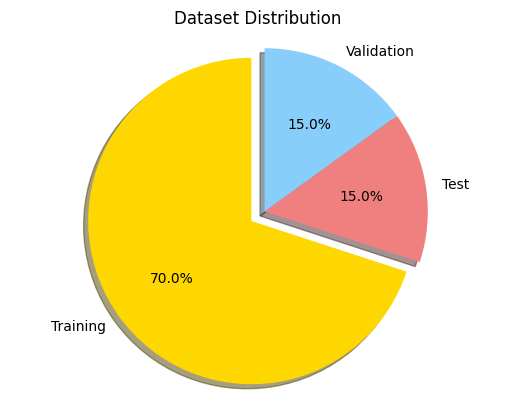

In [5]:
# # We are going to create a training,test and validation array, 70% - training, 15% - test, 15% - cross validation

#reshape Y
correted_Y = np.argmax(correted_Y, axis=1)
correted_Y = correted_Y.reshape(-1, 1)

# reshape dataset to 2D, removing the third dimension
X_flatten = correted_X.reshape(correted_X.shape[0], correted_X.shape[1] * correted_X.shape[2])

# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_flatten, correted_Y, test_size=0.3, random_state=42)

# Split the test set into test and validation sets
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Print the shapes of the training, test and validation sets
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}')

print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')

train_percent = len(Y_train) / len(correted_Y)
test_percent = len(Y_test) / len(correted_Y)
val_percent = len(Y_val) / len(correted_Y)

# Plotting the pie chart
labels = 'Training', 'Test', 'Validation'
sizes = [train_percent, test_percent, val_percent]
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0)  # only "explode" the 1st slice (training)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Dataset Distribution')
plt.show()

## Confusion Matrix function

We will create a function to plot the confusion matrix.

In [8]:
# Define train and analyse model functions
from sklearn.model_selection import GridSearchCV, KFold, validation_curve, cross_validate


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Model training and evaluation

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

def train_and_evaluate_svm(X_train, y_train, X_test, y_test, X_val, y_val):
    # Transformando rótulos em forma numérica
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train.ravel())
    y_test_encoded = encoder.transform(y_test.ravel())
    y_val_encoded = encoder.transform(y_val.ravel())
    
    # Criando e treinando o modelo SVM
    svm_model = SVC(kernel='linear')  # Começando com um kernel linear
    
    scores = cross_val_score(svm_model, X_flatten, correted_Y.ravel(), cv=5, scoring='accuracy')

    # Plot dos resultados
    plt.plot(scores)
    plt.title('Cross-Validation Accuracy Scores')
    plt.show()
    
    svm_model.fit(X_train, y_train_encoded)
    
    datasets = [
        (X_train, y_train_encoded, 'Train'),
        (X_test, y_test_encoded, 'Test'),
        (X_val, y_val_encoded, 'Validation')
    ]
    
    for X, y, set_name in datasets:
        y_pred = svm_model.predict(X)
        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='weighted')
        print(f"\n---- {set_name} Set ----")
        print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
        
        print("Classification Report:")
        print(classification_report(y, y_pred))
        
        cm = confusion_matrix(y, y_pred)
        print("Confusion Matrix:")
        plot_confusion_matrix(cm, target_names=np.unique(y).astype(str), title=f'{set_name} Set Confusion Matrix', normalize=False)
    
    # Retornar o modelo e o encoder
    return svm_model, encoder

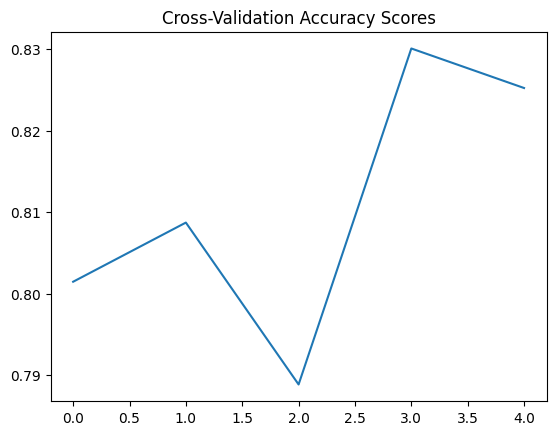


---- Train Set ----
Accuracy: 1.0000, F1 Score: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       136
           2       1.00      1.00      1.00       130
           3       1.00      1.00      1.00       143
           4       1.00      1.00      1.00       155
           5       1.00      1.00      1.00       152
           6       1.00      1.00      1.00       142
           7       1.00      1.00      1.00       144
           8       1.00      1.00      1.00       146
           9       1.00      1.00      1.00       145

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443

Confusion Matrix:


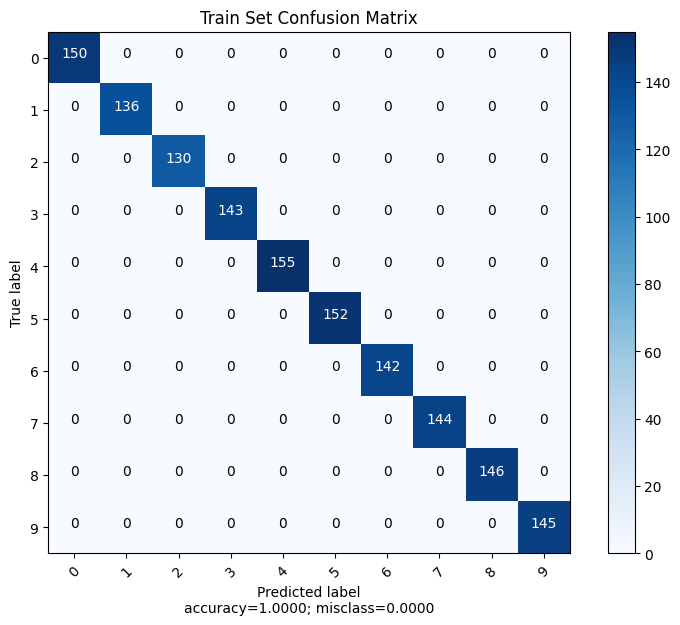


---- Test Set ----
Accuracy: 0.8123, F1 Score: 0.8126
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.86        27
           1       0.95      0.92      0.93        38
           2       0.74      0.80      0.77        35
           3       0.90      0.90      0.90        30
           4       0.73      0.75      0.74        32
           5       0.88      0.88      0.88        24
           6       0.81      0.74      0.77        34
           7       0.68      0.72      0.70        32
           8       0.81      0.75      0.78        28
           9       0.88      0.76      0.81        29

    accuracy                           0.81       309
   macro avg       0.82      0.81      0.81       309
weighted avg       0.82      0.81      0.81       309

Confusion Matrix:


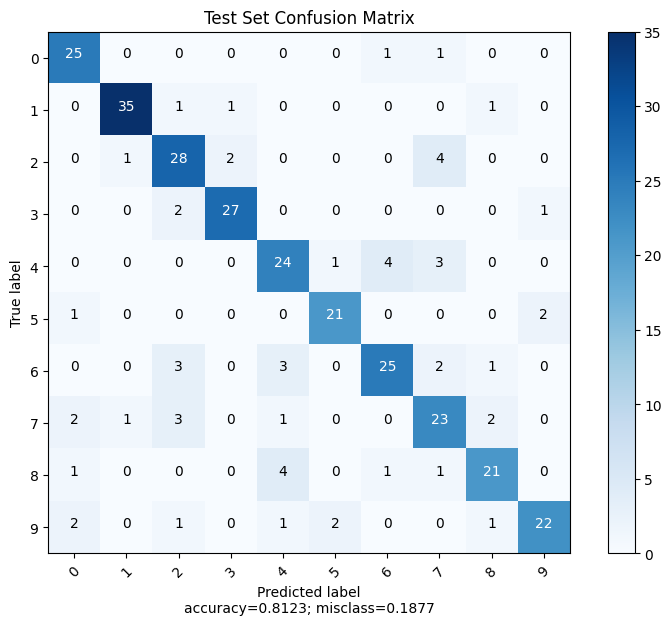


---- Validation Set ----
Accuracy: 0.8129, F1 Score: 0.8104
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        28
           1       0.84      0.81      0.83        32
           2       0.83      0.71      0.76        41
           3       0.85      0.85      0.85        33
           4       0.53      0.50      0.51        20
           5       0.88      0.94      0.91        31
           6       0.77      0.77      0.77        31
           7       0.77      0.90      0.83        30
           8       0.86      0.74      0.79        34
           9       0.84      0.87      0.85        30

    accuracy                           0.81       310
   macro avg       0.80      0.81      0.80       310
weighted avg       0.81      0.81      0.81       310

Confusion Matrix:


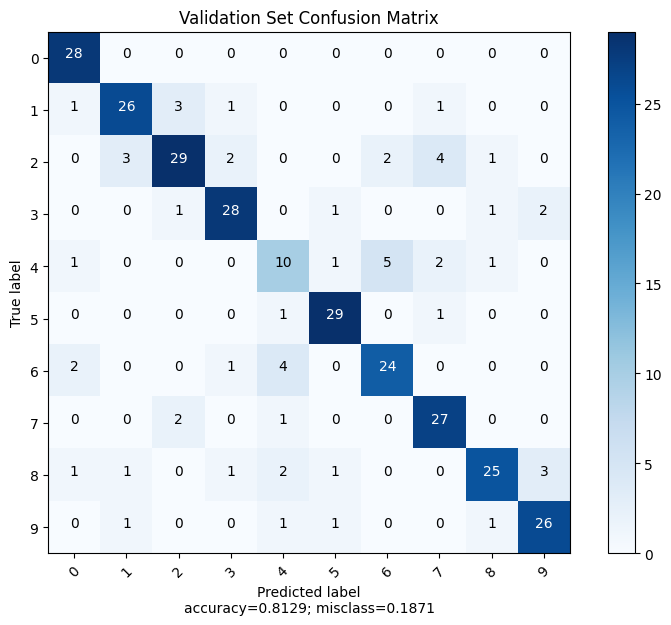

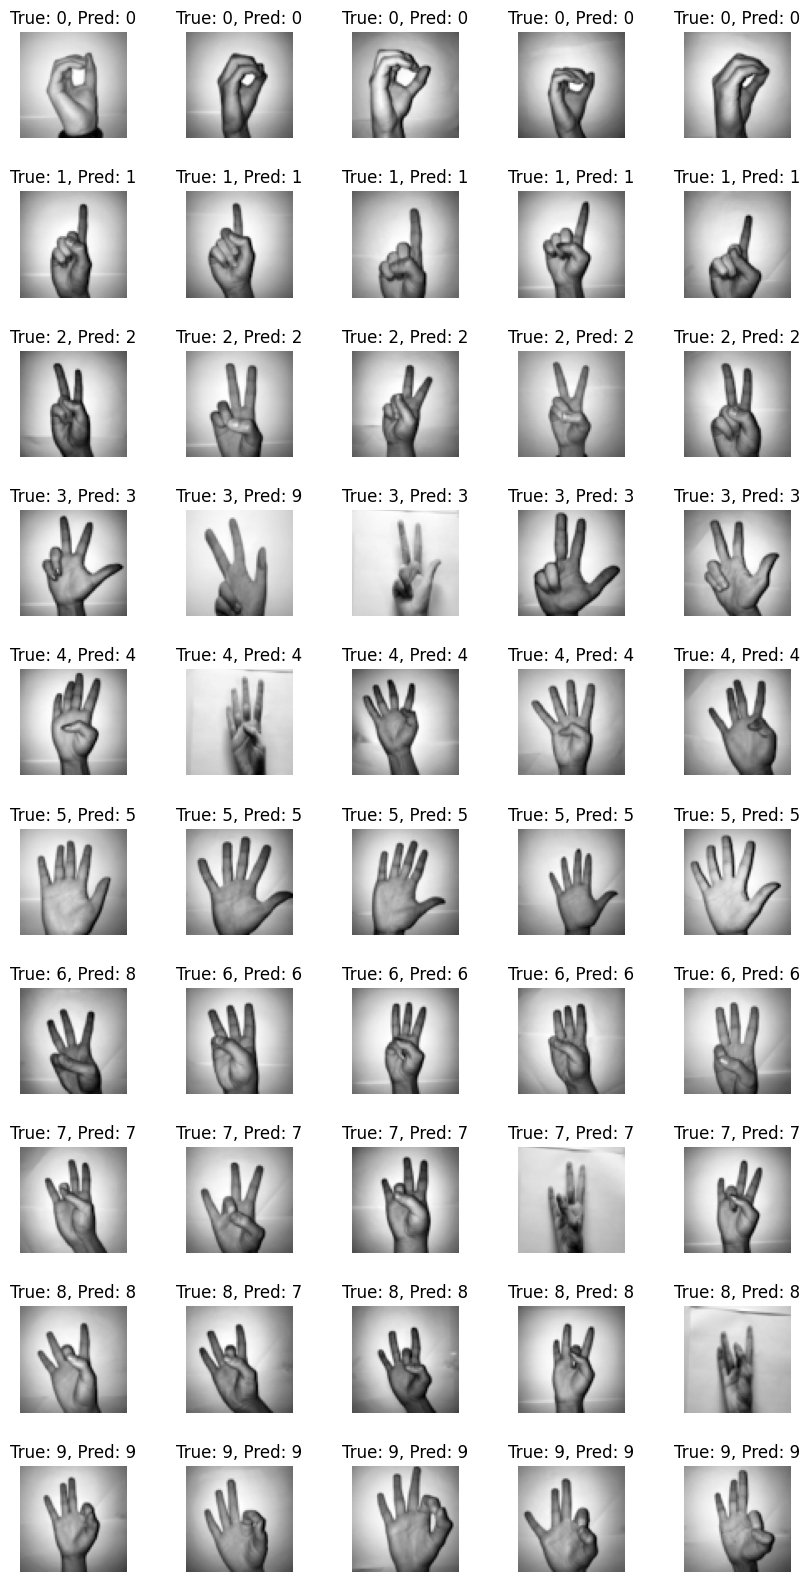

In [14]:
svm_model, encoder = train_and_evaluate_svm(X_train, Y_train, X_test, Y_test, X_val, Y_val)

if len(correted_Y.shape) > 1:
    correted_Y = correted_Y.ravel()

# Escolha imagens aleatórias para teste
random_images = []

for i in range(10):  # Assumindo 10 classes
    random_images.append(np.where(correted_Y == i)[0][0:5])

random_images = np.array(random_images).flatten()

# Plotar as imagens com previsões
fig, axes = plt.subplots(10, 5, figsize=(10, 20))

for idx, image_idx in enumerate(random_images):
    i, j = divmod(idx, 5)
    axes[i, j].imshow(correted_X[image_idx], cmap='gray')
    axes[i, j].axis('off')
    
    # Preparar a imagem para predição
    image_prepared = X_flatten[image_idx].reshape(1, -1)
    
    # Fazer a predição
    pred_label = svm_model.predict(image_prepared)[0]  # Sem np.argmax
    
    # Usar encoder para obter o rótulo original se o encoder foi utilizado
    if encoder is not None:
        pred_label = encoder.inverse_transform([pred_label])[0]
    
    true_label = correted_Y[image_idx]
    
    axes[i, j].set_title(f'True: {true_label}, Pred: {pred_label}')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()


## Hyperparameter tuning

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

def svm_hyperparameter_tuning(X_train, y_train):
    # Transformando rótulos em forma numérica
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train.ravel())
    
    # Definindo o modelo
    svm_model = SVC()
    
    # Definindo a grade de hiperparâmetros para testar
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
        'gamma': ['scale', 'auto', 0.01, 0.001],
        'degree': [2, 3, 4],
        'coef0': [0.0, 0.1, 0.5],
        'shrinking': [True, False],
        'probability': [True, False],
        'tol': [1e-3, 1e-4, 1e-5],
        'class_weight': [None, 'balanced']
    }
    
    # Criando o objeto GridSearchCV
    grid_search = GridSearchCV(svm_model, param_grid, refit=True, verbose=3, scoring='accuracy', cv=5)
    
    # Executando o grid search
    grid_search.fit(X_train, y_train_encoded)
    
    # Melhores parâmetros e melhor score
    print("Melhores parâmetros:", grid_search.best_params_)
    print("Melhor score:", grid_search.best_score_)
    
    # Retornando o melhor modelo
    return grid_search.best_estimator_, encoder

# Treinando o modelo e realizando hyperparameter tuning
best_svm_model, encoder = svm_hyperparameter_tuning(X_train, Y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.107 total time=   3.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.107 total time=   3.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.107 total time=   3.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.108 total time=   3.3s


KeyboardInterrupt: 